In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score
import time
import pandas as pd

In [2]:
SVHN_train = torchvision.datasets.SVHN('/home/vbhandaru/PycharmProjects/FinalProject/',split='train', download=True, transform=torchvision.transforms.ToTensor())
SVHN_test = torchvision.datasets.SVHN('/home/vbhandaru/PycharmProjects/FinalProject/', split='test', download=True, transform=torchvision.transforms.ToTensor())

Using downloaded and verified file: /home/vbhandaru/PycharmProjects/FinalProject/train_32x32.mat
Using downloaded and verified file: /home/vbhandaru/PycharmProjects/FinalProject/test_32x32.mat


In [3]:
tr = np.array([SVHN_train[i][0].numpy() for i in range(len(SVHN_train))])
means = [np.mean(tr[:, i, :, :]) for i in [0,1,2]]
std = [np.std(tr[:, i, :, :]) for i in [0,1,2]]
print(means, std)

([0.43768218, 0.44376934, 0.47280428], [0.1980301, 0.2010157, 0.19703591])


In [4]:
transformation = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Normalize((0.43768218, 0.44376934, 0.47280428), (0.1980301, 0.2010157, 0.19703591))])

SVHN_train = torchvision.datasets.SVHN('/home/vbhandaru/PycharmProjects/FinalProject/',split='train', download=True, transform=transformation)
SVHN_test = torchvision.datasets.SVHN('/home/vbhandaru/PycharmProjects/FinalProject/', split='test', download=True, transform=transformation)


Using downloaded and verified file: /home/vbhandaru/PycharmProjects/FinalProject/train_32x32.mat
Using downloaded and verified file: /home/vbhandaru/PycharmProjects/FinalProject/test_32x32.mat


In [5]:
#Separate training into training and validation
print(len(SVHN_train), len(SVHN_test))
a = list(range(len(SVHN_train)))
np.random.seed(5)
np.random.shuffle(a)
val_indices = a[0:7000]
train1_indices = a[7000:]
val = [SVHN_train[i] for i in val_indices]
train1 = [SVHN_train[i] for i in train1_indices]
print(len(val), len(train1))

(73257, 26032)
(7000, 66257)


In [6]:
def conv_train(train_data=SVHN_train, num_epochs=10, batch_size=100, val_data=None, validate=0):
    start = time.time()
    criterion = torch.nn.CrossEntropyLoss()
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
    if validate==1:
        val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
    for epoch in range(num_epochs):
        if epoch%10==0: print("epoch ", epoch)
        model.train()
        for data in train_loader:
            inputs, labels = data
            inputs = Variable(inputs.cuda())
            labels = Variable(labels.cuda())
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        if validate==1:
            model.eval()
            for i, data in enumerate(val_loader):
                inputs, labels = data
                inputs = Variable(inputs.cuda())
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                if i==0:
                    df = pd.DataFrame({'Predicted':list(preds), 'Actual': list(labels)})
                if i>0:
                    df1 = pd.DataFrame({'Predicted':list(preds), 'Actual': list(labels)})
                    df = pd.concat([df, df1])
            epoch_acc = accuracy_score(df['Actual'], df['Predicted'])
            acc1 = pd.DataFrame({'Epoch': [epoch], 'Accuracy': [epoch_acc] })
            if epoch==0:
                acc = acc1
            else:
                acc = pd.concat([acc, acc1])
            model.eval()
            for i, data in enumerate(train_loader):
                inputs, labels = data
                inputs = Variable(inputs.cuda())
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                if i==0:
                    df_train = pd.DataFrame({'Predicted':list(preds), 'Actual': list(labels)})
                if i>0:
                    df1_train = pd.DataFrame({'Predicted':list(preds), 'Actual': list(labels)})
                    df_train = pd.concat([df_train, df1_train])
            epoch_acc_train = accuracy_score(df_train['Actual'], df_train['Predicted'])
            acc1_train = pd.DataFrame({'Epoch': [epoch], 'Accuracy': [epoch_acc_train] })
            if epoch==0:
                acc_train = acc1_train
            else:
                acc_train = pd.concat([acc_train, acc1_train])
    end = time.time()
    t1 = end-start
    print str(t1) + ' seconds'
    if validate==1: 
        acc = acc.rename(columns={'Accuracy': 'Validation accuracy'}).merge(acc_train.rename(columns={'Accuracy': 'Training accuracy'}), on='Epoch').set_index('Epoch')
        acc.plot(title='Training and validation accuracy')
        return acc 

In [7]:
class Flatten(torch.nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    

In [8]:
def conv_test(batch_size=1000, testds=SVHN_test, report=0):
    model.eval()
    test_loader = torch.utils.data.DataLoader(testds, batch_size=batch_size, shuffle=True)
    for i,data in enumerate(test_loader):
        inputs, labels = data
        inputs = Variable(inputs.cuda())
        labels = labels.cuda()
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        if i==0:
            df = pd.DataFrame({'Predicted':list(preds), 'Actual': list(labels)})
        if i>0:
            df1 = pd.DataFrame({'Predicted':list(preds), 'Actual': list(labels)})
            df = pd.concat([df, df1])
    print(testds)
    if report==1:
        print(classification_report(df['Actual'], df['Predicted']))
    print(accuracy_score(df['Actual'], df['Predicted']))
    return df

('epoch ', 0)
('epoch ', 10)
('epoch ', 20)
('epoch ', 30)
('epoch ', 40)
('epoch ', 50)
('epoch ', 60)
('epoch ', 70)
('epoch ', 80)
('epoch ', 90)
271.076822996 seconds
             precision    recall  f1-score   support

          0       0.83      0.82      0.82      1744
          1       0.89      0.92      0.90      5099
          2       0.88      0.87      0.88      4149
          3       0.75      0.77      0.76      2882
          4       0.89      0.82      0.86      2523
          5       0.82      0.82      0.82      2384
          6       0.80      0.77      0.78      1977
          7       0.80      0.87      0.83      2019
          8       0.81      0.70      0.75      1660
          9       0.75      0.79      0.77      1595

avg / total       0.83      0.83      0.83     26032

0.8333973570989551


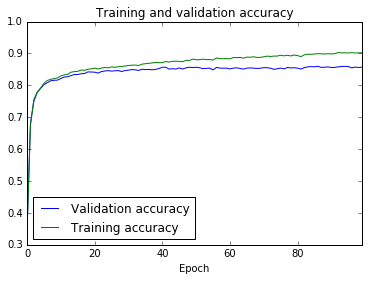

In [9]:
#1 layer
model = torch.nn.Sequential(
        torch.nn.Conv2d(3,20,5),
        torch.nn.MaxPool2d(2, stride=1),
        torch.nn.ReLU(),
        torch.nn.Dropout2d(0.25),
        Flatten(),
        torch.nn.Linear(14580, 100), 
        torch.nn.ReLU(),
        torch.nn.Linear(100, 10), 
        torch.nn.LogSoftmax()
        ).cuda() 
optimizer =torch.optim.Adam(model.parameters(),lr=0.001)
acc1 = conv_train(train_data=train1, num_epochs=100, batch_size=1000, val_data=val, validate=1)
ctest1 = conv_test(report=1)

('epoch ', 0)
('epoch ', 10)
('epoch ', 20)
('epoch ', 30)
('epoch ', 40)
('epoch ', 50)
('epoch ', 60)
('epoch ', 70)
('epoch ', 80)
('epoch ', 90)
375.279681921 seconds
             precision    recall  f1-score   support

          0       0.86      0.90      0.88      1744
          1       0.91      0.94      0.92      5099
          2       0.94      0.90      0.92      4149
          3       0.81      0.85      0.83      2882
          4       0.92      0.87      0.90      2523
          5       0.89      0.88      0.89      2384
          6       0.86      0.83      0.85      1977
          7       0.92      0.88      0.90      2019
          8       0.82      0.81      0.82      1660
          9       0.81      0.86      0.83      1595

avg / total       0.88      0.88      0.88     26032

0.8830285802089736


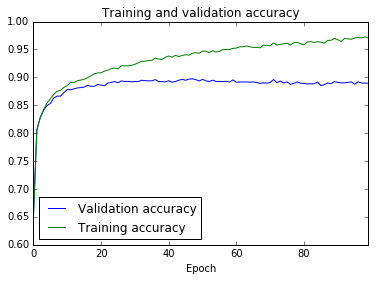

In [10]:
#2 layers
model = torch.nn.Sequential(
        torch.nn.Conv2d(3,20,5),
        torch.nn.MaxPool2d(2, stride=1),
        torch.nn.ReLU(),
        torch.nn.Conv2d(20,20,5),
        torch.nn.MaxPool2d(2, stride=1),
        torch.nn.ReLU(),
        torch.nn.Dropout2d(0.25),
        Flatten(),
        torch.nn.Linear(9680, 150), 
        torch.nn.ReLU(),
        torch.nn.Linear(150, 10), 
        torch.nn.LogSoftmax()
        ).cuda() 
optimizer =torch.optim.Adam(model.parameters(),lr=0.001)
acc2 = conv_train(train_data=train1, num_epochs=100, batch_size=1000, val_data=val, validate=1)
ctest2 = conv_test(report=1)

('epoch ', 0)
('epoch ', 10)
('epoch ', 20)
('epoch ', 30)
('epoch ', 40)
('epoch ', 50)
('epoch ', 60)
('epoch ', 70)
('epoch ', 80)
('epoch ', 90)
453.274827003 seconds
             precision    recall  f1-score   support

          0       0.90      0.90      0.90      1744
          1       0.93      0.95      0.94      5099
          2       0.94      0.93      0.93      4149
          3       0.89      0.86      0.88      2882
          4       0.93      0.91      0.92      2523
          5       0.90      0.90      0.90      2384
          6       0.86      0.88      0.87      1977
          7       0.91      0.92      0.91      2019
          8       0.88      0.85      0.86      1660
          9       0.85      0.88      0.87      1595

avg / total       0.91      0.91      0.91     26032

0.9056545789797172


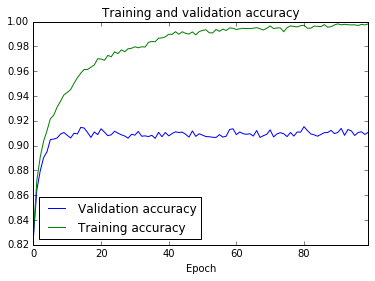

In [11]:
#3 layers
model = torch.nn.Sequential(
        torch.nn.Conv2d(3,20,5),
        torch.nn.MaxPool2d(2, stride=1),
        torch.nn.ReLU(),
        torch.nn.Conv2d(20,20,5),
        torch.nn.MaxPool2d(2, stride=1),
        torch.nn.ReLU(),
        torch.nn.Conv2d(20,20,5),
        torch.nn.MaxPool2d(2, stride=1),
        torch.nn.ReLU(),
        torch.nn.Dropout2d(0.25),
        Flatten(),
        torch.nn.Linear(5780, 250), 
        torch.nn.ReLU(),
        torch.nn.Linear(250, 10), 
        torch.nn.LogSoftmax()
        ).cuda() 
optimizer =torch.optim.Adam(model.parameters(),lr=0.001)
acc3 = conv_train(train_data=train1, num_epochs=100, batch_size=1000, val_data=val, validate=1)
ctest3 = conv_test(report=1)

('epoch ', 0)
('epoch ', 10)
('epoch ', 20)
('epoch ', 30)
('epoch ', 40)
('epoch ', 50)
('epoch ', 60)
('epoch ', 70)
('epoch ', 80)
('epoch ', 90)
508.126682997 seconds
             precision    recall  f1-score   support

          0       0.90      0.89      0.89      1744
          1       0.94      0.92      0.93      5099
          2       0.92      0.93      0.93      4149
          3       0.86      0.86      0.86      2882
          4       0.92      0.90      0.91      2523
          5       0.95      0.86      0.91      2384
          6       0.85      0.89      0.87      1977
          7       0.89      0.92      0.90      2019
          8       0.86      0.85      0.86      1660
          9       0.78      0.89      0.83      1595

avg / total       0.90      0.90      0.90     26032

0.8970497848801475


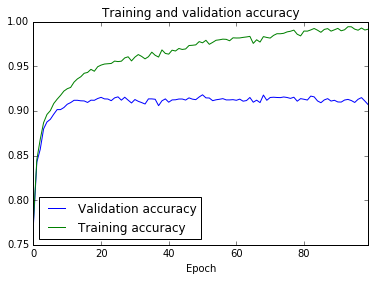

In [13]:
#4 layers
model = torch.nn.Sequential(
        torch.nn.Conv2d(3,20,5),
        torch.nn.MaxPool2d(2, stride=1),
        torch.nn.ReLU(),
        torch.nn.Conv2d(20,20,5),
        torch.nn.MaxPool2d(2, stride=1),
        torch.nn.ReLU(),
        torch.nn.Conv2d(20,20,5),
        torch.nn.MaxPool2d(2, stride=1),
        torch.nn.ReLU(),
        torch.nn.Conv2d(20,20,5),
        torch.nn.MaxPool2d(2, stride=1),
        torch.nn.ReLU(),
        torch.nn.Dropout2d(0.25),
        Flatten(),
        torch.nn.Linear(2880, 500), 
        torch.nn.ReLU(),
        torch.nn.Linear(500, 10), 
        torch.nn.LogSoftmax()
        ).cuda() 
optimizer =torch.optim.Adam(model.parameters(),lr=0.001)
acc4 = conv_train(train_data=train1, num_epochs=100, batch_size=1000, val_data=val, validate=1)
ctest4 = conv_test(report=1)

('epoch ', 0)
('epoch ', 10)
('epoch ', 20)
('epoch ', 30)
('epoch ', 40)
('epoch ', 50)
('epoch ', 60)
('epoch ', 70)
('epoch ', 80)
('epoch ', 90)
538.271965027 seconds
             precision    recall  f1-score   support

          0       0.89      0.89      0.89      1744
          1       0.92      0.93      0.93      5099
          2       0.91      0.94      0.93      4149
          3       0.86      0.87      0.87      2882
          4       0.92      0.89      0.91      2523
          5       0.89      0.91      0.90      2384
          6       0.86      0.88      0.87      1977
          7       0.93      0.89      0.91      2019
          8       0.86      0.83      0.85      1660
          9       0.88      0.85      0.86      1595

avg / total       0.90      0.90      0.90     26032

0.8986631837738168


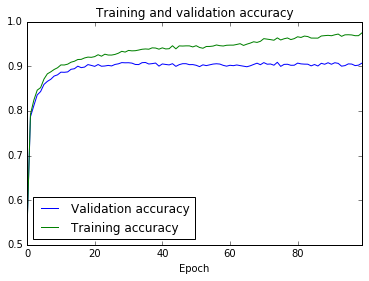

In [14]:
#5 layers
model = torch.nn.Sequential(
        torch.nn.Conv2d(3,20,5),
        torch.nn.MaxPool2d(2, stride=1),
        torch.nn.ReLU(),
        torch.nn.Conv2d(20,20,5),
        torch.nn.MaxPool2d(2, stride=1),
        torch.nn.ReLU(),
        torch.nn.Conv2d(20,20,5),
        torch.nn.MaxPool2d(2, stride=1),
        torch.nn.ReLU(),
        torch.nn.Conv2d(20,20,5),
        torch.nn.MaxPool2d(2, stride=1),
        torch.nn.ReLU(),
        torch.nn.Conv2d(20,20,5),
        torch.nn.MaxPool2d(2, stride=1),
        torch.nn.ReLU(),
        torch.nn.Dropout2d(0.25),
        Flatten(),
        torch.nn.Linear(980, 1400), 
        torch.nn.ReLU(),
        torch.nn.Linear(1400, 10), 
        torch.nn.LogSoftmax()
        ).cuda() 
optimizer =torch.optim.Adam(model.parameters(),lr=0.001)
acc5 = conv_train(train_data=train1, num_epochs=100, batch_size=1000, val_data=val, validate=1)
ctest5 = conv_test(report=1)

('epoch ', 0)
('epoch ', 10)
('epoch ', 20)
('epoch ', 30)
('epoch ', 40)
('epoch ', 50)
('epoch ', 60)
('epoch ', 70)
('epoch ', 80)
('epoch ', 90)
366.549758911 seconds
             precision    recall  f1-score   support

          0       0.93      0.89      0.91      1744
          1       0.94      0.95      0.94      5099
          2       0.93      0.95      0.94      4149
          3       0.87      0.90      0.88      2882
          4       0.95      0.91      0.93      2523
          5       0.93      0.90      0.91      2384
          6       0.89      0.90      0.89      1977
          7       0.93      0.90      0.92      2019
          8       0.87      0.89      0.88      1660
          9       0.89      0.90      0.89      1595

avg / total       0.92      0.92      0.92     26032

0.9159496004917025


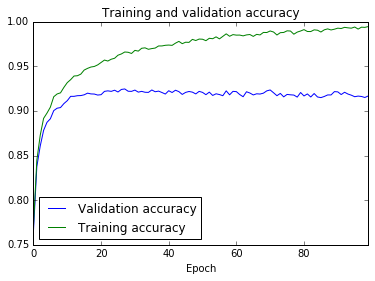

In [15]:
model = torch.nn.Sequential(
        torch.nn.Conv2d(3,20,5),
        torch.nn.MaxPool2d(2, stride=2),
        torch.nn.ReLU(),
        torch.nn.Conv2d(20,50,5),
        torch.nn.MaxPool2d(2, stride=1),
        torch.nn.ReLU(),
        torch.nn.Conv2d(50,50,5),
        torch.nn.MaxPool2d(2, stride=1),
        torch.nn.ReLU(),
        torch.nn.Dropout2d(0.25),
        Flatten(),
        torch.nn.Linear(800, 700), 
        torch.nn.ReLU(),
        torch.nn.Linear(700, 10), 
        torch.nn.LogSoftmax()
        ).cuda()
optimizer =torch.optim.Adam(model.parameters(),lr=0.001)
acc3_2 = conv_train(train_data=train1, num_epochs=100, batch_size=1000, val_data=val, validate=1)
ctest3_2 = conv_test(report=1)

In [16]:
pd.crosstab(ctest3_2['Actual'], ctest3_2['Predicted'])

Predicted,0,1,2,3,4,5,6,7,8,9
Actual,,,,,,,,,,
0,1557,21,17,22,6,7,46,10,17,41
1,27,4823,43,59,38,18,9,46,32,4
2,5,30,3932,72,14,15,13,32,26,10
3,9,43,48,2599,9,54,15,14,39,52
4,9,85,29,32,2293,12,18,13,16,16
5,7,13,17,113,14,2137,48,4,17,14
6,20,14,16,29,10,45,1778,4,49,12
7,5,99,50,24,5,2,2,1820,6,6
8,13,13,13,29,12,14,57,4,1476,29
